# SmolVLM - small yet mighty Vision Language Model

In [1]:
!pip install -q pytubefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.0/732.0 kB 11.4 MB/s eta 0:00:00


In [25]:
from typing import List


from pytubefix import YouTube
from pytubefix.cli import on_progress
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoProcessor, Idefics3ForConditionalGeneration



DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running experiment on {DEVICE}")

Running experiment on cuda


## Utils

In [3]:
def download_youtube_video(url: str, dest: str="/content"):
    yt = YouTube(url, on_progress_callback=on_progress)
    ys = yt.streams.get_highest_resolution()
    ys.download(output_path=dest)

In [4]:
URL = "https://www.youtube.com/watch?v=EdF3IFPi7Co"
download_youtube_video(url=URL) # destination: dest/<video name.mp4>

In [16]:
class VideoFrameExtractor:
    def __init__(self, max_frames: int = 50):
        self.max_frames = max_frames

    def resize_and_center_crop(self,
                               image: Image.Image,
                               target_size: int) -> Image.Image:
        # Get current dimensions
        width, height = image.size

        # Calculate new dimensions keeping aspect ratio
        if width < height:
            new_width = target_size
            new_height = int(height * (target_size / width))
        else:
            new_height = target_size
            new_width = int(width * (target_size / height))

        # Resize
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Center crop
        left = (new_width - target_size) // 2
        top = (new_height - target_size) // 2
        right = left + target_size
        bottom = top + target_size

        return image.crop((left, top, right, bottom))

    def extract_frames(self, video_path: str) -> List[Image.Image]:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        # Get video properties
        self.total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Calculate frame indices to extract (1fps)
        frame_indices = list(range(0, self.total_frames, self.fps))

        # If we have more frames than max_frames, sample evenly
        if len(frame_indices) > self.max_frames:
            indices = np.linspace(0, len(frame_indices) - 1, self.max_frames, dtype=int)
            frame_indices = [frame_indices[i] for i in indices]

        frames = []
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame)
                pil_image = self.resize_and_center_crop(pil_image, 384)
                frames.append(pil_image)

        cap.release()
        return frames

In [23]:
video_extractor = VideoFrameExtractor(max_frames=10)
frames = video_extractor.extract_frames("/content/HD Cooktasty Food Ultra Slow Motion 4k video Creative Common Cooking chef.mp4")


print(f"Extracted {len(frames)} frames")
print(f"Total frames: {video_extractor.total_frames}")
print(f"FPS: {video_extractor.fps}")

Extracted 10 frames
Total frames: 998
FPS: 25


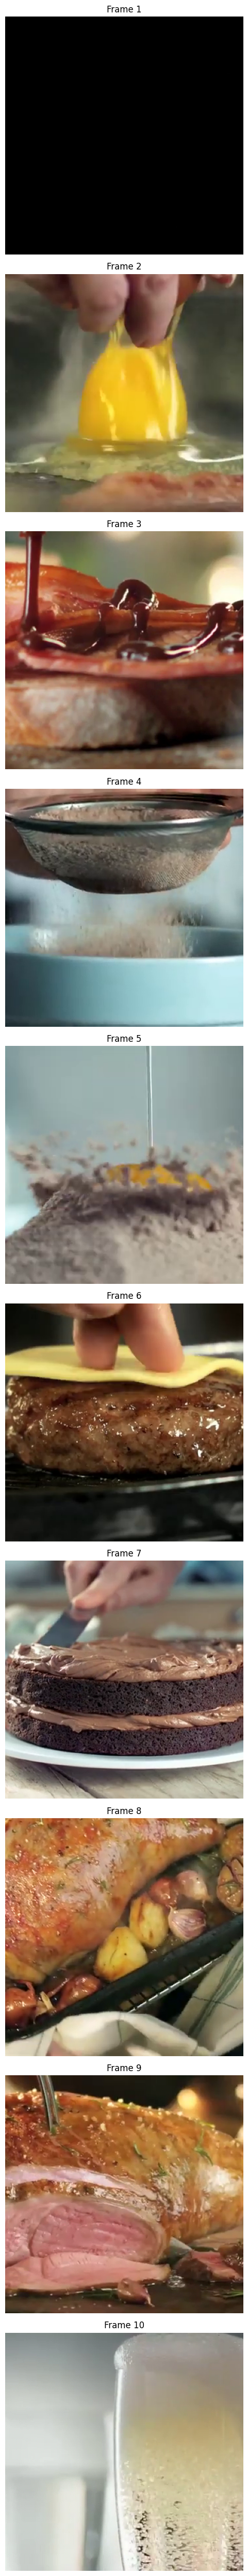

In [28]:
# Display all frames using matplotlib
plt.figure(figsize=(15, len(frames) * 5))  # Adjust size for better visualization

for idx, frame in enumerate(frames):
    plt.subplot(len(frames), 1, idx + 1)
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"Frame {idx + 1}")

plt.tight_layout()
plt.show()

In [6]:
def load_model(checkpoint_path: str,
               base_model_id: str = "HuggingFaceTB/SmolVLM-Instruct",
               device: str = "cuda"):
    # Load processor from original model
    processor = AutoProcessor.from_pretrained(base_model_id)
    if checkpoint_path:
        # Load fine-tuned model from checkpoint
        model = Idefics3ForConditionalGeneration.from_pretrained(
            checkpoint_path,
            torch_dtype=torch.bfloat16,
            device_map=device
        )
    else:
        model = Idefics3ForConditionalGeneration.from_pretrained(
            base_model_id,
            torch_dtype=torch.bfloat16,
            device_map=device
        )

    # Configure processor for video frames
    processor.image_processor.size = (384, 384)
    processor.image_processor.do_resize = False
    processor.image_processor.do_image_splitting = False

    return model, processor

In [7]:
def generate_response(model,
                      processor,
                      video_path: str,
                      question: str,
                      max_frames: int = 100):
    # Extract frames
    frame_extractor = VideoFrameExtractor(max_frames)
    frames = frame_extractor.extract_frames(video_path)
    print(f"Extracted {len(frames)} frames from video")

    # Create prompt with frames
    image_tokens = [{"type": "image"} for _ in range(len(frames))]
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Answer briefly."},
                *image_tokens,
                {"type": "text", "text": question}
            ]
        }
    ]

    # Process inputs
    inputs = processor(
        text=processor.apply_chat_template(messages, add_generation_prompt=True),
        images=[img for img in frames],
        return_tensors="pt"
    ).to(model.device)

    # Generate response
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        num_beams=5,
        temperature=0.7,
        do_sample=True,
        use_cache=True
    )

    # Decode response
    response = processor.decode(outputs[0], skip_special_tokens=True)
    return response

## Inference

In [8]:
# Configuration
#checkpoint_path = "/path/to/your/checkpoint"
checkpoint_path = None
base_model_id = "HuggingFaceTB/SmolVLM-Instruct"
video_path = "/content/HD Cooktasty Food Ultra Slow Motion 4k video Creative Common Cooking chef.mp4"
question = "Describe the video"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
print("Loading model...")
model, processor = load_model(checkpoint_path, base_model_id, device)


Loading model...


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [12]:
model

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_

In [13]:
processor

Idefics3Processor:
- image_processor: Idefics3ImageProcessor {
  "do_convert_rgb": true,
  "do_image_splitting": false,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": false,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "Idefics3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "max_image_size": {
    "longest_edge": 384
  },
  "processor_class": "Idefics3Processor",
  "resample": 1,
  "rescale_factor": 0.00392156862745098,
  "size": [
    384,
    384
  ]
}

- tokenizer: GPT2TokenizerFast(name_or_path='HuggingFaceTB/SmolVLM-Instruct', vocab_size=49152, model_max_length=16384, is_fast=True, padding_side='right', truncation_side='left', special_tokens={'bos_token': '<|im_start|>', 'eos_token': '<end_of_utterance>', 'unk_token': '<|endoftext|>', 'pad_token': '<|im_end|>', 'additional_special_tokens': ['<fake_token_around_image>', '<image>', '<end_of_utterance>']}, clean_up_tokenization_spaces=False, added_token

In [31]:

# Generate response
print("Generating response...")
response = generate_response(model,
                             processor,
                             video_path,
                             question,
                             max_frames=10)

Generating response...
Extracted 10 frames from video


In [32]:
# Print results
print("Question:", question)
print("Response:", response)

Question: Describe the video
Response: User: Answer briefly.<image>Describe the video
Assistant: The video shows a close-up shot of a hand holding a metal strainer over a plate of food. The hand is squeezing the strainer, and the food is spilling out of the strainer and onto the plate. The food appears to be a hamburger patty, and there is a slice of cheese on top of the patty. The hamburger patty is cooked and has grill marks on it. The cheese is melted and slightly browned. The plate is white
